# Cross-Modal Redundancy and the Geometry of Vision–Language Embeddings

This notebook illustrates some of the results presented in the paper "Cross-Modal Redundancy and the Geometry of Vision–Language Embeddings", published as a conference paper at ICLR 2026.

The main contributions of this work are:
- Formalizing hypotheses about the data generative process behind vision-language embeddings as emerging from a shared latent variable model
    - *See definitions 1 and 2.*
- operationalizing these hypotheses through sparse autoencoders with added regularization
    - *See the "**Operationalization**" paragraph.*
- identify shared and modality-specific atoms
    - Atoms satisfying the IsoEnergy condition are refered to as *bimodal*, those that do not are *unimodal*.
    - Atoms carrying cross-modal information are refered to as *cross-modal*, those that do not are *modality-specific*.
    - We carefully identify *bimodal* atoms with *cross-modal* atoms, and *unimodal* atoms with *modality-specific* atoms through metrics and experiments.
- formal proof showing that, under near orthogonality assumptions, modality specific atoms do not contribute to cross-modal retrieval
    - *See proposition 1.*
- systematic interventions showing that
    - shared atoms are necessary and sufficient for cross-modal retrieval
        - *$\delta_r$ and its complement*
    - modality specific atoms do encode relevant information
        - *Imagenet classification accuracy after intervention drops significantly but stays orders of magnitude above chance*
    - for cross modal transfer, modality specific atoms act as noise
        - *semantic vector arithmetic experiments*

## 0. Set up

In [1]:
import os
os.chdir("/home/gdhimola/MultimodalGeometry/")

import torch
import numpy as np

from tqdm import tqdm
import overcomplete

import matplotlib.pyplot as plt
import seaborn as sns

from src import losses, train, metrics
from src.utils import (
    get_coco, get_laion, get_imagenet, get_fashionIQ,
    _train,
    measure_everything, measure_bridge, get_bridge_norms,
    get_rho,
    _intervene
)
from src.utils import (
    plot_energy, plot_energy_cdf, plot_E_vs_E_B,
    plot_modality_energy, mu_vs_mu_B,
    plot_bridges,
)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

/home/gdhimola/.conda/envs/multimodal/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# constants
use_model = "clip"  # openclip or siglip
modality_threshold = 0.05

In [3]:
if use_model == "clip":
    model_name = "openai/clip-vit-base-patch32"
    d_model = 512
    beta = 4e-4
elif use_model == "clip-L":
    model_name = "openai/clip-vit-large-patch14"
    d_model = 768
    beta = 1e-4
elif use_model == "openclip":
    model_name="laion/CLIP-ViT-B-32-laion2B-s34B-b79K"
    d_model = 512
    beta = 4e-4
elif use_model == "openclip-L":
    model_name="laion/CLIP-ViT-L-14-laion2B-s32B-b82K"
    d_model = 768
    beta = 2e-4
elif use_model == "siglip":
    model_name = "google/siglip-base-patch16-224"
    d_model = 768
    beta = 1e-4
elif use_model == "siglip2":
    model_name = "google/siglip2-base-patch16-224"
    d_model = 768
    beta = 7e-5
else:
    raise NotImplementedError(f"Model {use_model} not recognized.")

## 1. Train and load models

train a standard SAE and an aligned SAE for comparison

In [4]:
laion_loader = get_laion(device=device, model_name=model_name)

In [5]:
SSAE, SSAE_name, _ = _train(beta=0, train_loader=laion_loader, model_name=model_name, d_model=d_model, archi="MP", device=device, expansion_factor=8, top_k=20) #, force_retrain=True, save_quand_meme=True) # Standard SAE
ASAE, ASAE_name, _ = _train(beta=beta, train_loader=laion_loader, model_name=model_name, d_model=d_model, archi="MP", device=device, expansion_factor=8, top_k=20) #, force_retrain=True, save_quand_meme=True) # Aligned SAE

Model name: openai/clip-vit-base-patch32/laion_MP_centered_False_8_L0_20_alpha00beta0
Model name: openai/clip-vit-base-patch32/laion_MP_centered_False_8_L0_20_alpha00beta00004


measure energy, modality score etc ...

In [6]:
SSAE.metrics = measure_everything(SSAE, laion_loader, device, return_sqr=True)
ASAE.metrics = measure_everything(ASAE, laion_loader, device, return_sqr=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1283/1283 [00:23<00:00, 54.20it/s]


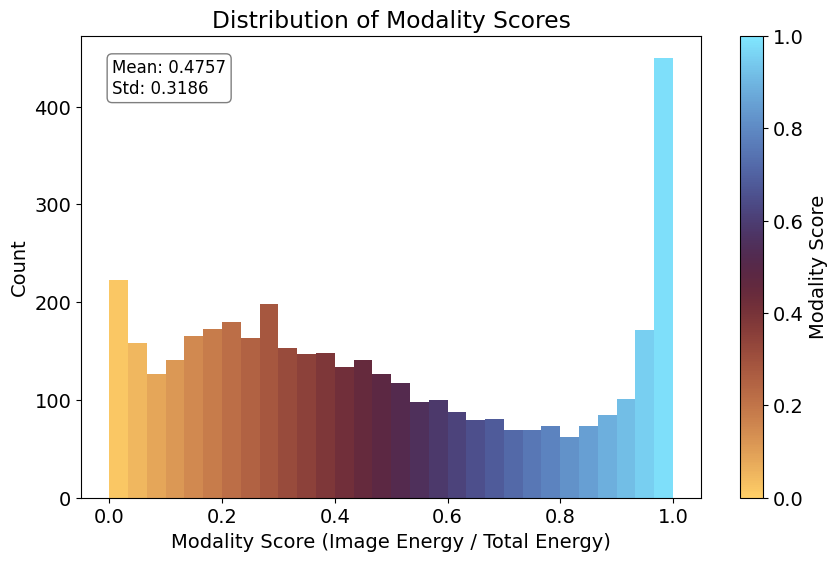

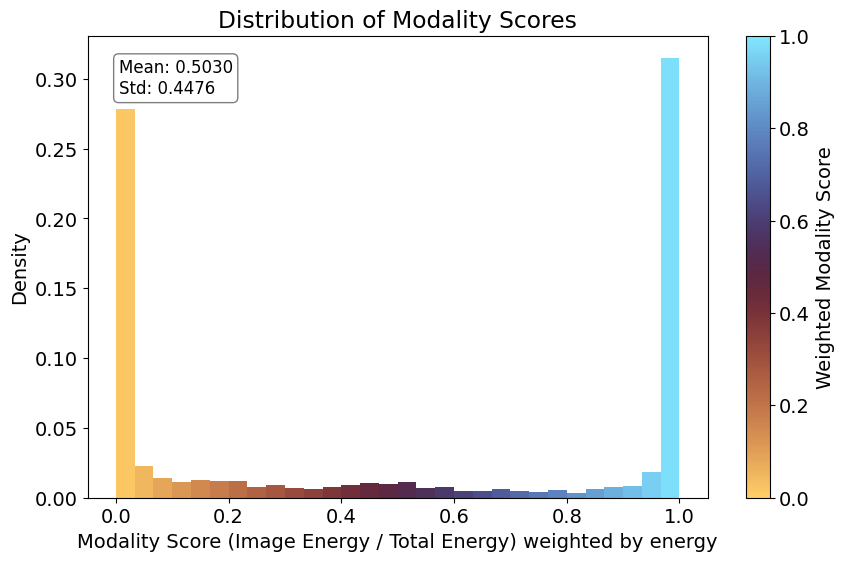

/home/gdhimola/MultimodalGeometry/src/utils.py:2538: UserWarning: Only one of 'bins' and 'norm' arguments can be supplied, ignoring bins='log'
  plt.hexbin(x, y, C=((x + y) / (x + y).sum() if weighted else None), reduce_C_function=(np.sum if weighted else None), gridsize=100, bins='log', cmap='magma_r', xscale='log', yscale='log', norm=(LogNorm(vmin=max(1e-4, ((x + y) / (x + y).sum()).min())) if weighted else None))


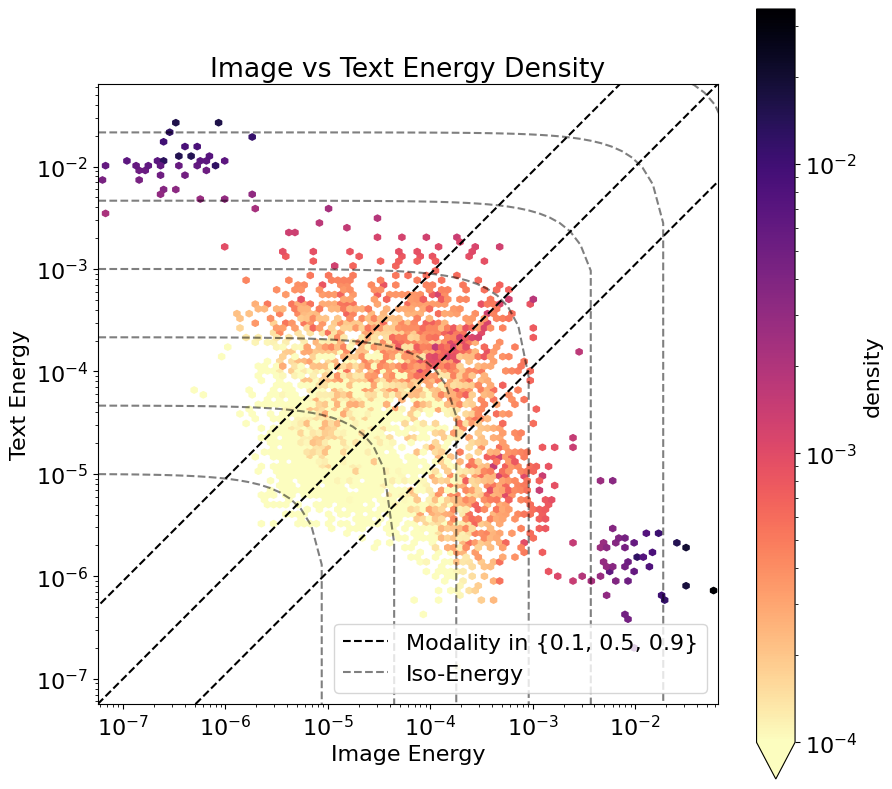

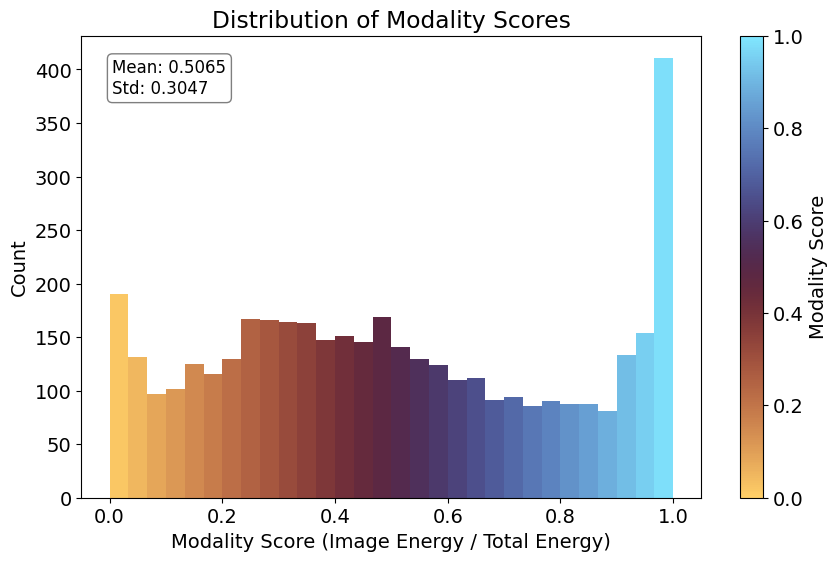

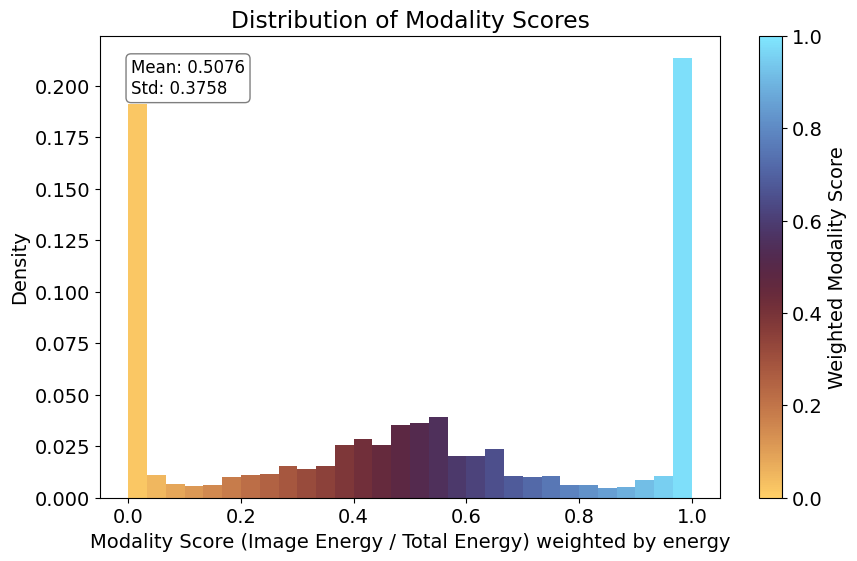

/home/gdhimola/MultimodalGeometry/src/utils.py:2538: UserWarning: Only one of 'bins' and 'norm' arguments can be supplied, ignoring bins='log'
  plt.hexbin(x, y, C=((x + y) / (x + y).sum() if weighted else None), reduce_C_function=(np.sum if weighted else None), gridsize=100, bins='log', cmap='magma_r', xscale='log', yscale='log', norm=(LogNorm(vmin=max(1e-4, ((x + y) / (x + y).sum()).min())) if weighted else None))


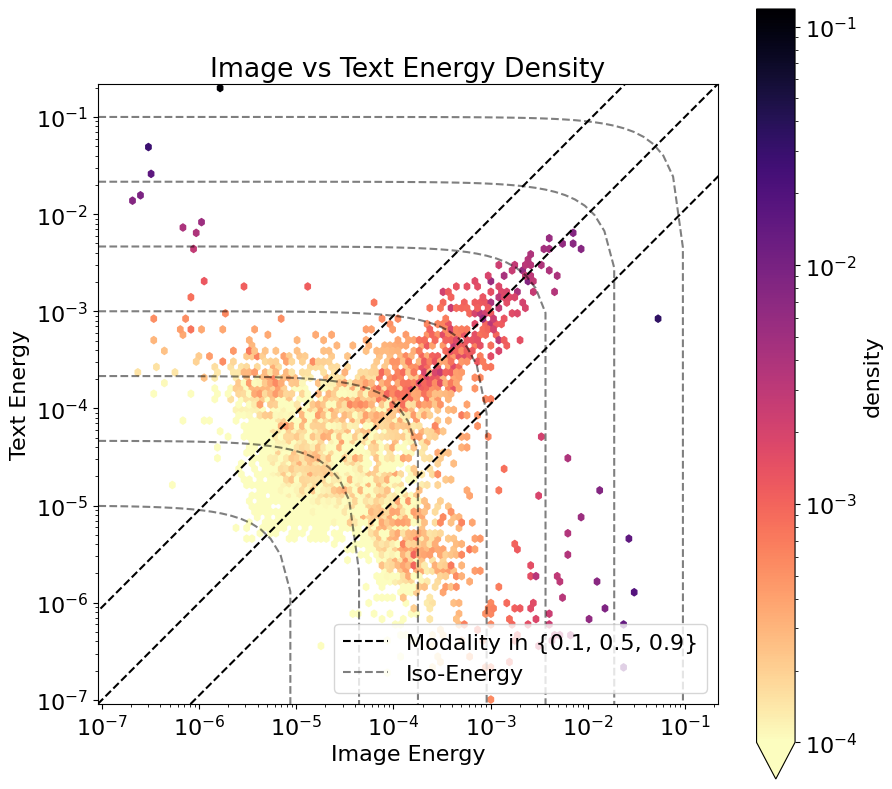

In [7]:
plot_modality_energy(SSAE, SSAE_name)
plot_modality_energy(ASAE, ASAE_name)

side by side energy distributions :

<p align="center">
  <img src="images/E_distrib_SSAE.png" width="45%">
  <img src="images/E_distrib_ASAE.png" width="45%">
</p>

## 2. Identification

Show that *bimodal* = *cross-modal* and *unimodal* = *modality-specific*

Intervention metric :

- difference in retrieval accuracy when ablating bimodal atoms
    - significant drop : bimodal atoms are necessary
    - no drop : unimodal atoms are sufficient
- difference in retrieval accuracy when ablating unimodal atoms
    - no drop : bimodal atoms are sufficient
    - significant drop : unimodal atoms are necessary
    - **This metric is reported as "$\delta_r$" in the paper.**

In [8]:
@torch.no_grad()
def recall(I, T, top_k=1, batch_size=256, shuffle=True): # , logit_scale=4.6052): useless for accuracy, doesn't change ordeging
    num_batches = I.shape[0] // batch_size
    
    correct_pairs = 0
    total_pairs = 0
    
    labels = torch.arange(batch_size, device=I.device)
    
    if shuffle:
        perm = torch.randperm(I.shape[0], device='cpu')
    for i in tqdm(range(num_batches)):
        I_batch = I[perm[i * batch_size:(i + 1) * batch_size]]
        T_batch = T[perm[i * batch_size:(i + 1) * batch_size]]

        # Compute cosine similarity
        I_batch = I_batch / (I_batch.norm(dim=1, keepdim=True) + 1e-8)
        T_batch = T_batch / (T_batch.norm(dim=1, keepdim=True) + 1e-8)
        logits_per_image = I_batch @ T_batch.T
        logits_per_text = T_batch @ I_batch.T

        logits_per_image = logits_per_image # * logit_scale
        logits_per_text = logits_per_text # * logit_scale
        
        topk_image = logits_per_image.topk(k=top_k, dim=1).indices
        topk_text = logits_per_text.topk(k=top_k, dim=1).indices

        correct_image = (topk_image == labels.unsqueeze(1)).any(dim=1).sum().item()
        correct_text = (topk_text == labels.unsqueeze(1)).any(dim=1).sum().item()
        
        correct_pairs += (correct_image + correct_text) / 2
        total_pairs += batch_size
        
    accuracy = correct_pairs / total_pairs
    return accuracy


In [9]:
@torch.no_grad()
def run_recall(loader):
    def _compute(sae):
        print("Computing reconstructed...") 
        reconstructed_I, reconstructed_T, _ = _intervene(sae, loader, sae.metrics.mu, device, eps=0, return_D=False)
        print("Done.")
        
        print("Computing Baselines...")
        baseline_mean_I, baseline_mean_T = reconstructed_I, reconstructed_T
        baseline_mean_I = baseline_mean_I - baseline_mean_I.mean(dim=0)
        baseline_mean_T = baseline_mean_T - baseline_mean_T.mean(dim=0)
        
        baseline_mean = recall(baseline_mean_I, baseline_mean_T)
        del baseline_mean_I, baseline_mean_T
        
        baseline_shift_I, baseline_shift_T = reconstructed_I, reconstructed_T
        Delta = baseline_shift_I.mean(dim=0) - baseline_shift_T.mean(dim=0)
        baseline_shift_I = baseline_shift_I - Delta/2
        baseline_shift_T = baseline_shift_T + Delta/2
        
        baseline_shift = recall(baseline_shift_I, baseline_shift_T)
        del baseline_shift_I, baseline_shift_T
        
        baseline_rd_I, baseline_rd_T = reconstructed_I, reconstructed_T
        Delta = baseline_rd_I.mean(dim=0) - baseline_rd_T.mean(dim=0)
        baseline_rd_I = baseline_rd_I - Delta/2
        baseline_rd_T = baseline_rd_T + Delta/2
    
        baseline_rd = recall(baseline_rd_I, baseline_rd_T)
        del baseline_rd_I, baseline_rd_T
        print("Done.")
        
        reconstructed = recall(reconstructed_I, reconstructed_T)
        del reconstructed_I, reconstructed_T
    
        print("Computing Bimodal...")
        bi_I, bi_T, _ = _intervene(sae, loader, sae.metrics.mu, device, return_D=False, eps=0.05)
        bi = recall(bi_I, bi_T)
        del bi_I, bi_T
        print("Done.")
        
        print("Computing Unimodal...")
        uni_I, uni_T, _ = _intervene(sae, loader, sae.metrics.mu, device, complement=True, return_D=False, eps=0.05)
        uni = recall(uni_I, uni_T)
        del uni_I, uni_T
        print("Done.")
        
        return baseline_mean, baseline_shift, baseline_rd, reconstructed, bi, uni
    
    baseline_mean_S, baseline_shift_S, baseline_rd_S, reconstructed_S, bi_S, uni_S = _compute(SSAE)
    baseline_mean_A, baseline_shift_A, baseline_rd_A, reconstructed_A, bi_A, uni_A = _compute(ASAE)
    
    return (
        baseline_mean_S, baseline_shift_S, baseline_rd_S, reconstructed_S, bi_S, uni_S,
        baseline_mean_A, baseline_shift_A, baseline_rd_A, reconstructed_A, bi_A, uni_A,
    )

In [10]:
(baseline_mean_S, baseline_shift_S, baseline_rd_S, reconstructed_S, bi_S, uni_S,
 baseline_mean_A, baseline_shift_A, baseline_rd_A, reconstructed_A, bi_A, uni_A,
) = run_recall(laion_loader)

Computing reconstructed...


  0%|                                                                                                                                                                         | 0/1283 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1283/1283 [00:26<00:00, 47.80it/s]


Done.
Computing Baselines...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2565/2565 [00:00<00:00, 3315.32it/s]


Done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2565/2565 [00:00<00:00, 3225.42it/s]


Computing Bimodal...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2565/2565 [00:00<00:00, 3623.88it/s]


Done.
Computing Unimodal...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2565/2565 [00:00<00:00, 3418.83it/s]


Done.
Computing reconstructed...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1283/1283 [00:26<00:00, 47.85it/s]


Done.
Computing Baselines...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2565/2565 [00:00<00:00, 3570.77it/s]


Done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2565/2565 [00:00<00:00, 3601.06it/s]


Computing Bimodal...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2565/2565 [00:00<00:00, 3368.97it/s]


Done.
Computing Unimodal...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2565/2565 [00:00<00:00, 3263.69it/s]

Done.


In [11]:
print("--- Reference retrieval accuracy for LAION: ---")
print(f"Reconstructed - go through the autoencoder\n\tSSAE: {reconstructed_S:.4f}, ASAE: {reconstructed_A:.4f}")

print("\n--- baseline interventions ---")
print(f"Mean baseline - remove modality-wise mean\n\tSSAE: {baseline_mean_S:.4f}, ASAE: {baseline_mean_A:.4f}")
print(f"Shift baseline - remove modality-wise mean and add global mean\n\tSSAE: {baseline_shift_S:.4f}, ASAE: {baseline_shift_A:.4f}")
print(f"Random baseline - remove modality-wise mean and add random vector\n\tSSAE: {baseline_rd_S:.4f}, ASAE: {baseline_rd_A:.4f}")

print("\n--- concept level interventions ---")
print(f"Bimodal - go through the autoencoder, zero-out unimodal atoms\n\tSSAE: {bi_S:.4f}, ASAE: {bi_A:.4f}")
print(f"Unimodal - go through the autoencoder, zero-out bimodal atoms\n\tSSAE: {uni_S:.4f}, ASAE: {uni_A:.4f}")

--- Reference retrieval accuracy for LAION: ---
Reconstructed - go through the autoencoder
	SSAE: 0.8871, ASAE: 0.8579

--- baseline interventions ---
Mean baseline - remove modality-wise mean
	SSAE: 0.9030, ASAE: 0.8771
Shift baseline - remove modality-wise mean and add global mean
	SSAE: 0.6898, ASAE: 0.6891
Random baseline - remove modality-wise mean and add random vector
	SSAE: 0.6896, ASAE: 0.6890

--- concept level interventions ---
Bimodal - go through the autoencoder, zero-out unimodal atoms
	SSAE: 0.7328, ASAE: 0.7468
Unimodal - go through the autoencoder, zero-out bimodal atoms
	SSAE: 0.0496, ASAE: 0.0047


**Results**
- For aligned SAE, bimodal atoms are necessary and sufficient for cross-modal retrieval
- For standard SAE, the default run shown here seems to have worked fine as well.

**Other metrics** : to help corroborate these findings and the fact that atoms are better organized in the aligned SAE :
- $p_\mathrm{acc}$ : Geometric insight. Summarizes whether *(i)* unimodal atoms are "aligned" with the modality gap (or whether they can be used to probe for modality membershiip), and *(ii)* bimodal atoms are "orthogonal" to it (or whether they can not be used to probe for modality membership).
- $\rho$ : Instance level activation patterns. Ratio of geometric alignment between matching pairs explained by bimodal atoms to that explained by unimodal atoms.
    - *Note : this metric does not take into account contrastive alignment, just raw alignment.*
- FDA : Same, but population level.
- $\delta_r$ : Intervention metric, explained above. Tests causal necessity and sufficiency of bimodal atoms for cross-modal retrieval.

## 3. Modality-specific atoms encode relevant information

... and are not just noise. Measure Imagenet classification accuracy when ablating bimodal atoms only.

In [12]:
imagenet_train_loader, _ = get_imagenet(batch_size=512, model_name=model_name, device=device, split="train")
imagenet_test_loader, class_embeddings = get_imagenet(batch_size=512, model_name=model_name, device=device)
train_labels  = imagenet_train_loader.dataset.tensors[1]
labels = imagenet_test_loader.dataset.tensors[1]
T_ImageNet = class_embeddings[labels]

/media/data_cifs/projects/multimodal/imagenet/embeddings/openai/clip-vit-base-patch32


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading ImageNet dataset from /media/data_cifs/projects/prj_video_imagenet/imagenet/ILSVRC/Data/CLS-LOC/val2...


Processing ImageNet images: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [06:08<00:00, 135.80it/s]


torch.Size([50000, 512])
File path : /media/data_cifs/projects/multimodal/imagenet/embeddings/openai/clip-vit-base-patch32/test.pt
torch.Size([1000, 512])


In [13]:
(baseline_mean_S, baseline_shift_S, baseline_rd_S, reconstructed_S, bi_S, uni_S,
 baseline_mean_A, baseline_shift_A, baseline_rd_A, reconstructed_A, bi_A, uni_A,
) = run_recall(
    torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(imagenet_test_loader.dataset.tensors[0], T_ImageNet),
        batch_size=256, shuffle=True
    )
)

Computing reconstructed...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:02<00:00, 77.54it/s]


Done.
Computing Baselines...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 2663.76it/s]


Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 3259.52it/s]


Computing Bimodal...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 3592.62it/s]


Done.
Computing Unimodal...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 3215.80it/s]


Done.
Computing reconstructed...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:02<00:00, 79.63it/s]


Done.
Computing Baselines...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 3588.68it/s]


Done.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 3595.78it/s]


Computing Bimodal...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 2700.13it/s]


Done.
Computing Unimodal...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 3555.38it/s]

Done.


In [14]:
print("--- Reference classification accuracy for ImageNet: ---")
print(f"Reconstructed - go through the autoencoder\n\tSSAE: {reconstructed_S:.4f}, ASAE: {reconstructed_A:.4f}")

# print("\n--- baseline interventions ---")
# print(f"Mean baseline - remove modality-wise mean\n\tSSAE: {baseline_mean_S:.4f}, ASAE: {baseline_mean_A:.4f}")
# print(f"Shift baseline - remove modality-wise mean and add global mean\n\tSSAE: {baseline_shift_S:.4f}, ASAE: {baseline_shift_A:.4f}")
# print(f"Random baseline - remove modality-wise mean and add random vector\n\tSSAE: {baseline_rd_S:.4f}, ASAE: {baseline_rd_A:.4f}")

print("\n--- concept level interventions ---")
# print(f"Bimodal - go through the autoencoder, zero-out unimodal atoms\n\tSSAE: {bi_S:.4f}, ASAE: {bi_A:.4f}")
print(f"Unimodal - go through the autoencoder, zero-out bimodal atoms\n\tSSAE: {uni_S:.4f}, ASAE: {uni_A:.4f}")

--- Reference classification accuracy for ImageNet: ---
Reconstructed - go through the autoencoder
	SSAE: 0.4757, ASAE: 0.4528

--- concept level interventions ---
Unimodal - go through the autoencoder, zero-out bimodal atoms
	SSAE: 0.0069, ASAE: 0.0037


**Results**
- Using *zero-shot accuracy* (cf. Appendix E.1.), the performance plummets to chance level. This is expected, as what allows for zero-shot classification is cross-modal alignment, which is carried by bimodal atoms that we just removed. It does not mean there is no relevant information left in the embeddings ! For that, we need to look at *classifier accuracy*.

In [40]:
def train_linear_classifier(train_loader, num_classes, epochs=1):
    from torch.nn import Sequential, BatchNorm1d, Linear, CrossEntropyLoss
    from torch.optim import Adam
    from torch.optim.lr_scheduler import LambdaLR
    import matplotlib.pyplot as plt
    from IPython.display import display, clear_output

    in_dim = train_loader.dataset.tensors[0].shape[1]
    model = Sequential(
        BatchNorm1d(in_dim),
        Linear(in_dim, num_classes)
    ).to(device)

    base_lr = 1e-3
    optimizer = Adam(model.parameters(), lr=base_lr)
    criterion = CrossEntropyLoss()

    # Scheduler: warmup + cosine decay
    warmup_steps = 50
    total_steps = len(train_loader) * 5

    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        decay_ratio = (step - warmup_steps) / (total_steps - warmup_steps)
        return 0.5 * (1 + torch.cos(torch.tensor(decay_ratio * 3.1415926535)))

    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

    model.train()
    losses = []

    for epoch in range(epochs):
        pbar = tqdm(train_loader)
        for images_features, labels in pbar:
            images_features = images_features.to(device)
            labels = labels.to(device)

            logits = model(images_features)
            loss = criterion(logits, labels)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | LR: {scheduler.get_last_lr()[0]:.2e}")

    return model

@torch.no_grad()
def zero_shot_transfer(test_loader, model, top_k=1):
    model.eval()
    correct = 0
    total = 0
    for images_features, labels in test_loader:
        images_features = images_features.to(device)
        labels = labels.to(device)

        logits = model(images_features)
        topk = logits.topk(k=top_k, dim=1).indices
        correct += (topk == labels.unsqueeze(1)).any(dim=1).sum().item()
        total += labels.size(0)

    return correct / total

def train_and_evaluate_classifier(data_tensor, test_tensor, train_labels, test_labels, num_classes=1000, epochs=1):
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data_tensor, train_labels), batch_size=512, shuffle=True)
    test_loader  = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_tensor, test_labels), batch_size=512, shuffle=True)

    clf = train_linear_classifier(train_loader, num_classes=num_classes, epochs=epochs)
    clfacc = zero_shot_transfer(test_loader, clf)
    return clfacc

In [ ]:
train_reconstructed_I, _, _ = _intervene(ASAE, imagenet_train_loader, ASAE.metrics.mu, device, eps=0, return_D=False)
test_reconstructed_I, _, _ = _intervene(ASAE, imagenet_test_loader, ASAE.metrics.mu, device, eps=0, return_D=False)
r_clfacc = train_and_evaluate_classifier(
    train_reconstructed_I,
    test_reconstructed_I,
    train_labels, labels, epochs=5
)
del train_reconstructed_I, test_reconstructed_I

train_bi_I, _, _ = _intervene(ASAE, imagenet_train_loader, ASAE.metrics.mu, device, return_D=False, eps=0.05)
test_bi_I, _, _ = _intervene(ASAE, imagenet_test_loader, ASAE.metrics.mu, device, return_D=False, eps=0.05)
bi_clfacc = train_and_evaluate_classifier(
    train_bi_I,
    test_bi_I,
    train_labels, labels, epochs=5
)
del train_bi_I, test_bi_I

train_uni_I, _, _ = _intervene(ASAE, imagenet_train_loader, ASAE.metrics.mu, device, complement=True, return_D=False, eps=0.05)
test_uni_I, _, _ = _intervene(ASAE, imagenet_test_loader, ASAE.metrics.mu, device, complement=True, return_D=False, eps=0.05)
uni_clfacc = train_and_evaluate_classifier(
    train_uni_I,
    test_uni_I,
    train_labels, labels, epochs=5
)
del train_uni_I, test_uni_I

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:01<00:00, 86.79it/s]
Epoch 1 | Loss: 2.6650 | LR: 9.71e-04: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 105.58it/s]
Epoch 2 | Loss: 1.7862 | LR: 7.52e-04: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 121.94it/s]
Epoch 3 | Loss: 1.3318 | LR: 4.15e-04: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 146.16it/s]
Epoch 4 | Loss: 1.1575 | LR: 1.17e-04: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 139.50it/s]


In [42]:
print(f"ImageNet Classifier Accuracy (ASAE):\n- Reconstructed: {r_clfacc:.4f}\n- Bimodal only: {bi_clfacc:.4f}\n- Unimodal only: {uni_clfacc:.4f}")
print(f"Random baseline : {1/1000:.4f}")

ImageNet Classifier Accuracy (ASAE):
- Reconstructed: 0.7763
- Bimodal only: 0.7620
- Unimodal only: 0.2329
Random baseline : 0.0010


**Results**
- Using classifier accuracy, we can see that most information seems to be lost but still enough remain to get about 20% accuracy on Imagenet classification (chance is at 0.1%).

## 4. Cross-modal transfer - semantic vector arithmetic

In [15]:
# download fashionIQ dataset

def download_fashionIQ():
    import os
    import json
    import urllib.request

    BROWN_fashionIQ_path = "/media/data_cifs/projects/prj_multimodal/fashion_iq/"
    base_dir = BROWN_fashionIQ_path
    os.makedirs(base_dir, exist_ok=True)

    def download_file(url, dest):
        if not os.path.exists(dest):
            urllib.request.urlretrieve(url, dest)

    # ---------- 1. Captions ----------
    caption_types = ["dress", "shirt", "toptee"]
    splits = ["train", "val", "test"]

    for ctype in caption_types:
        for split in splits:
            url = f"https://raw.githubusercontent.com/XiaoxiaoGuo/fashion-iq/master/captions/cap.{ctype}.{split}.json"
            dest = f"{base_dir}/captions/cap.{ctype}.{split}.json"
            os.makedirs(os.path.dirname(dest), exist_ok=True)
            download_file(url, dest)
            
    # ---------- 2. Image URLs ----------
    for ctype in caption_types:
        url = f"https://raw.githubusercontent.com/hongwang600/fashion-iq-metadata/master/image_url/asin2url.{ctype}.txt"
        dest = f"{base_dir}/image_url/asin2url.{ctype}.txt"
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        download_file(url, dest)

# download_fashionIQ()

Ablate unimodal atoms during cross-modal transfer experiments.

In [16]:
@torch.no_grad()
def fashion_recall(Q, T):
    """
    Compute recall for FashionIQ dataset.
    Q: Query embeddings
    T: Target image embeddings
    """
    rat10 = recall(Q, T, top_k=10)
    rat50 = recall(Q, T, top_k=50)
    return rat10, rat50

def benchmark_fashion_recall(Q, T):
    a, b = fashion_recall(Q, T)
    return (a + b) / 2


In [43]:
@torch.no_grad()
def fashion_OOD(ID, OOD, k=5):
    """
    Compute OOD score for queries against image distribution.
    Use the cosim distance to the K-th nearest neighbor.
    ID: In-distribution image embeddings, shape (N, d)
    OOD: Out-of-distribution queries, shape (M, d)
    returns: OOD scores, shape (M,)
    """
    ID /= (ID.norm(dim=1, keepdim=True) + 1e-8)  # Normalize ID embeddings
    OOD /= (OOD.norm(dim=1, keepdim=True) + 1e-8) # Normalize OOD embeddings
    
    batch_size = 256
    num_batches = OOD.shape[0] // batch_size + (OOD.shape[0] % batch_size > 0)
    
    ood_scores = torch.zeros(OOD.shape[0], device=OOD.device)
    
    for i in tqdm(range(num_batches)):
        OOD_batch = OOD[i * batch_size:(i + 1) * batch_size].to(ID.device)
        cosim = 1 - OOD_batch @ ID.T # shape (B, N)
        ood_scores[i * batch_size:(i + 1) * batch_size] = cosim.kthvalue(k=k, dim=1).values
    
    del ID, OOD, cosim

    return ood_scores


In [18]:
def plot_histograms(scores, labels, title="Histogram of Scores", xlabel="Score", ylabel="Density", kde=False):
    # scores : list of vectors
    # labels : list of strings, same length as scores. E.g. ["IID", "OOD"]
    
    plt.rcParams['font.size'] = 14

    plt.figure(figsize=(10, 6))
    
    for i, score in enumerate(scores):
        sns.histplot(score.cpu().detach(), bins=50, kde=kde, label=labels[i], binrange=[0, 1], stat='density')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"ood_baseline_mean", bbox_inches='tight', dpi=300)
    plt.show()
    plt.rcdefaults()


In [19]:
candidate_features, target_features, caption_features = get_fashionIQ(model_name=model_name, device=device)

# mask where candidate_features are 0, or target_features are 0 or caption_features are 0
mask = (candidate_features != 0).all(dim=1) & (target_features != 0).all(dim=1) & (caption_features != 0).all(dim=1)
candidate_features = candidate_features[mask]
target_features = target_features[mask]
caption_features = caption_features[mask]
print(f"Candidate features shape: {candidate_features.shape}")
print(f"Target features shape: {target_features.shape}")
print(f"Caption features shape: {caption_features.shape}")

cdd_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(candidate_features, torch.arange(candidate_features.shape[0])),
    batch_size=256, shuffle=False
)
trg_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(target_features, torch.arange(candidate_features.shape[0])),
    batch_size=256, shuffle=False
)
cap_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(caption_features, torch.arange(candidate_features.shape[0])),
    batch_size=256, shuffle=False
)

Processing captions: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18000/18000 [03:44<00:00, 80.22it/s]


Candidate features shape: torch.Size([18000, 512]), memory: 35.16 MB
Target features shape: torch.Size([18000, 512]), memory: 35.16 MB
Text features shape: torch.Size([18000, 512]), memory: 35.16 MB
Candidate features shape: torch.Size([16854, 512])
Target features shape: torch.Size([16854, 512])
Caption features shape: torch.Size([16854, 512])


In [20]:
ae_cdd, _, _ = _intervene(ASAE, cdd_loader, ASAE.metrics.mu, device, eps=0.0, complement=False, return_D=False)
ae_trg, _, _ = _intervene(ASAE, trg_loader, ASAE.metrics.mu, device, eps=0.0, complement=False, return_D=False)
ae_cap, _, _ = _intervene(ASAE, cap_loader, ASAE.metrics.mu, device, eps=0.0, complement=False, return_D=False)

bi_cdd, _, _ = _intervene(ASAE, cdd_loader, ASAE.metrics.mu, device, eps=0.05, complement=False, return_D=False)
bi_trg, _, _ = _intervene(ASAE, trg_loader, ASAE.metrics.mu, device, eps=0.05, complement=False, return_D=False)
bi_cap, _, _ = _intervene(ASAE, cap_loader, ASAE.metrics.mu, device, eps=0.05, complement=False, return_D=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 149.79it/s]


In [21]:
trg = ae_trg.cpu().detach()
cdd = ae_cdd.cpu().detach()
cap = ae_cap.cpu().detach()
retrieve = cdd + cap
intervene = cdd + bi_cap.cpu().detach()

In [22]:
cdd_score = benchmark_fashion_recall(cdd, trg)
cap_score = benchmark_fashion_recall(cap, trg)
retrieve_score = benchmark_fashion_recall(retrieve, trg)
intervene_score = benchmark_fashion_recall(intervene, trg)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 678.01it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 95.24it/s]


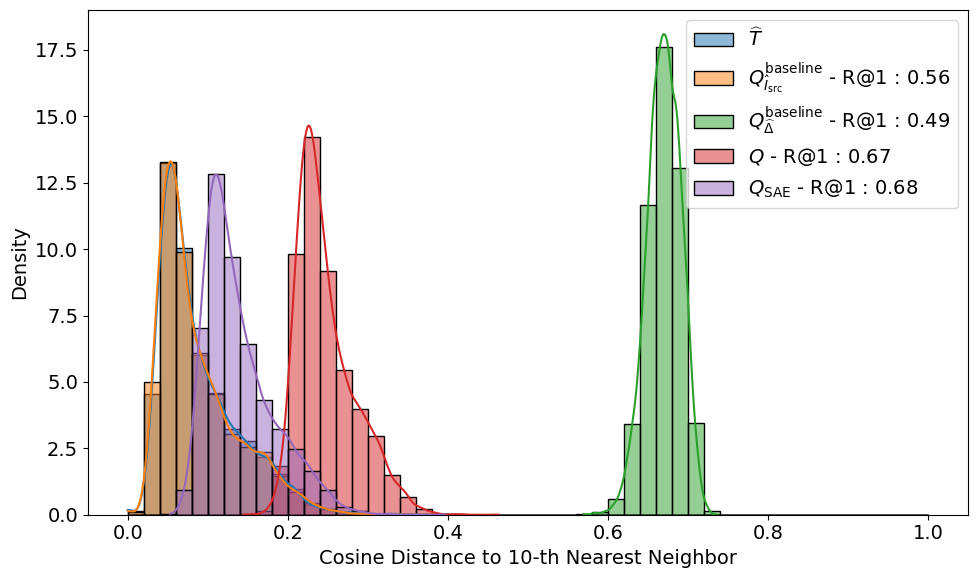

In [44]:
ood_cdd = fashion_OOD(trg, cdd).cpu().detach()
ood_cap = fashion_OOD(trg, cap).cpu().detach()
ood_retrieve = fashion_OOD(trg, retrieve).cpu().detach()
ood_intervene = fashion_OOD(trg, intervene).cpu().detach()

id = fashion_OOD(trg, trg).cpu().detach()

plot_histograms([id, ood_cdd, ood_cap, ood_retrieve, ood_intervene],
                [r"$\widehat{T}$",
                 r"$Q^\mathrm{baseline}_{\widehat{I}_{\mathrm{src}}}$ - R@1 : " + f"{cdd_score:.2f}",
                 r"$Q^\mathrm{baseline}_{\widehat{\Delta}}$ - R@1 : " + f"{cap_score:.2f}",
                 r"$Q$ - R@1 : " + f"{retrieve_score:.2f}",
                 r"$Q_{\mathrm{SAE}}$ - R@1 : "+f"{intervene_score:.2f}"
                ],
                title="",
                xlabel="Cosine Distance to 10-th Nearest Neighbor",
                ylabel="Density",
                kde=True
)

**Results**
- produces a distribution of target embeddings that is indistinguishable from the distribution of ground-truth target embeddings.
- actually increases performance (under fair comparison)


<p align="center">
  <img src="images/ood_fashion.png" width="45%">
</p>